In [1]:
!pip -q install kagglehub

import kagglehub
path = kagglehub.dataset_download("thedevastator/sms-spam-collection-a-more-diverse-dataset")
print("Path to dataset files:", path)


100%|██████████| 207k/207k [00:00<00:00, 392kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset/versions/2


Đọc dữ liệu

In [2]:
import os, glob
import pandas as pd

files = glob.glob(path + "/**/*", recursive=True)
files = [f for f in files if os.path.isfile(f)]
cand = [f for f in files if f.lower().endswith((".csv",".tsv"))]

if len(cand) == 0:
    raise Exception("Không tìm thấy file .csv hoặc .tsv trong dataset.")

data_path = cand[0]
print("Using file:", data_path)

if data_path.lower().endswith(".tsv"):
    df = pd.read_csv(data_path, sep="\t")
else:
    try:
        df = pd.read_csv(data_path)
    except:
        df = pd.read_csv(data_path, sep=None, engine="python")

df.columns = [c.lower().strip() for c in df.columns]
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

label_candidates = [c for c in df.columns if c in ["label","labels","class","category","v1","target","type"]]
text_candidates  = [c for c in df.columns if c in ["text","message","sms","content","v2","body"]]

label_col = label_candidates[0] if label_candidates else df.columns[0]
text_col  = text_candidates[0] if text_candidates else df.columns[1]

data = df[[label_col, text_col]].copy()
data.columns = ["label","text"]
data["label"] = data["label"].astype(str).str.strip()
data["text"]  = data["text"].astype(str).fillna("")

print("Using label_col =", label_col, "| text_col =", text_col)
display(data.head())


Using file: /root/.cache/kagglehub/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset/versions/2/train.csv
Shape: (5574, 2)
Columns: ['sms', 'label']


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Using label_col = label | text_col = sms


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# cố gắng chuẩn hoá nhãn về 'ham' và 'spam'
lab = data["label"].str.lower()

# các trường hợp hay gặp
data.loc[lab.isin(["spam","1","true","yes"]), "label"] = "spam"
data.loc[lab.isin(["ham","0","false","no","not spam","non-spam","not_spam","nonspam"]), "label"] = "ham"

# nếu dataset còn nhãn khác lạ, in ra để bạn biết
print("Unique labels after mapping:", sorted(data["label"].unique().tolist()))

# nếu vẫn không đúng 2 nhãn, bạn sẽ nhìn thấy ở đây để chỉnh


Unique labels after mapping: ['ham', 'spam']


PHÂN TÍCH DỮ LIỆU
3 — Thống kê: số mẫu, số nhãn, số lượng mỗi nhãn + kiểm tra mất cân bằng

In [4]:
import numpy as np

print("===== DATA OVERVIEW =====")
print("Số mẫu:", len(data))
print("Số nhãn:", data["label"].nunique())
print("Danh sách nhãn:", sorted(data["label"].unique().tolist()))

counts = data["label"].value_counts()
display(counts)

max_count = counts.max()
min_count = counts.min()
ratio = max_count / min_count if min_count > 0 else np.inf
print(f"Max/Min ratio = {ratio:.2f}")

if ratio < 1.5:
    print("=> Dữ liệu cân bằng / gần cân bằng.")
elif ratio < 3:
    print("=> Dữ liệu hơi mất cân bằng.")
elif ratio < 10:
    print("=> Dữ liệu mất cân bằng mức vừa.")
else:
    print("=> Dữ liệu mất cân bằng nặng.")


===== DATA OVERVIEW =====
Số mẫu: 5574
Số nhãn: 2
Danh sách nhãn: ['ham', 'spam']


,count
label,
ham,4827
spam,747


Max/Min ratio = 6.46
=> Dữ liệu mất cân bằng mức vừa.


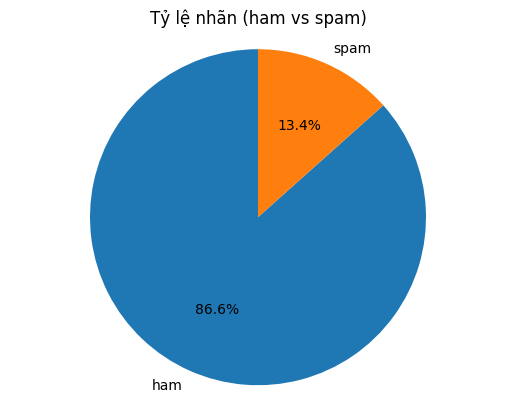

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.pie(counts.values, labels=counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Tỷ lệ nhãn (ham vs spam)")
plt.axis("equal")
plt.show()


Thống kê độ dài tin nhắn

In [6]:
data["len_chars"] = data["text"].str.len()
data["len_words"] = data["text"].str.split().apply(len)

display(data[["len_chars","len_words"]].describe())

# trung bình theo nhãn
display(data.groupby("label")[["len_chars","len_words"]].mean())


,len_chars,len_words
count,5574.000000,5574.000000
mean,81.478292,15.591676
std,59.848302,11.390454
min,3.000000,1.000000
25%,37.000000,7.000000
50%,63.000000,12.000000
75%,123.000000,23.000000
max,911.000000,171.000000


,len_chars,len_words
label,,
ham,72.471929,14.304123
spam,139.676037,23.911647


Biểu đồ phân phối độ dài tin nhắn (ham vs spam)

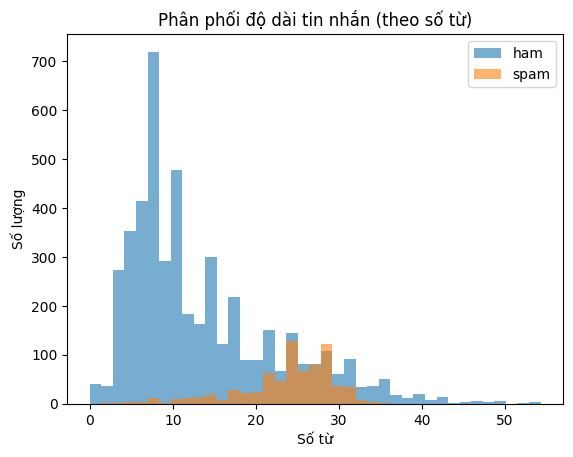

In [7]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, data["len_words"].quantile(0.99), 40)

plt.figure()
for lbl in sorted(data["label"].unique()):
    subset = data.loc[data["label"] == lbl, "len_words"]
    plt.hist(subset, bins=bins, alpha=0.6, label=lbl)
plt.title("Phân phối độ dài tin nhắn (theo số từ)")
plt.xlabel("Số từ")
plt.ylabel("Số lượng")
plt.legend()
plt.show()


Tỷ lệ URL/PHONE/MONEY

In [8]:
import re

url_re   = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
phone_re = re.compile(r"\b(\+?\d[\d\-\s]{7,}\d)\b")
money_re = re.compile(r"(\$|£|€)\s?\d+(\.\d+)?|\b\d+(\.\d+)?\s?(\$|£|€)\b")

data["has_url"]   = data["text"].apply(lambda x: 1 if url_re.search(x) else 0)
data["has_phone"] = data["text"].apply(lambda x: 1 if phone_re.search(x) else 0)
data["has_money"] = data["text"].apply(lambda x: 1 if money_re.search(x) else 0)

summary = data.groupby("label")[["has_url","has_phone","has_money"]].mean().sort_index()
display(summary)


,has_url,has_phone,has_money
label,,,
ham,0.000414,0.000414,0.002486
spam,0.141901,0.546185,0.341365


Top từ xuất hiện theo từng nhãn (ham vs spam)

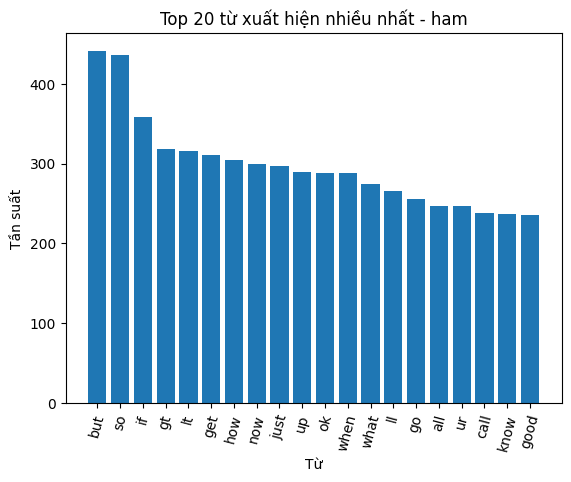

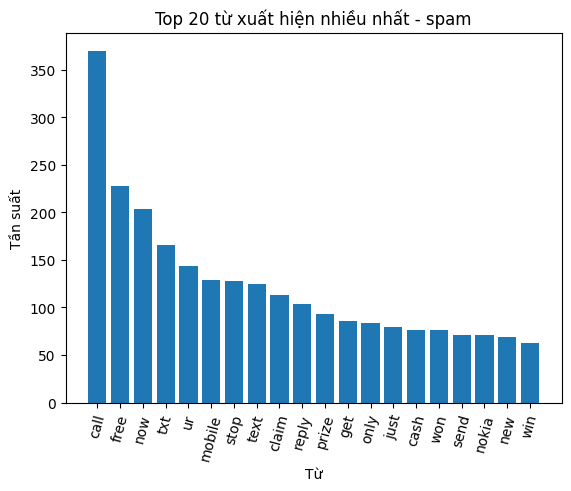

In [9]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# stopwords tiếng Anh tối giản (không cần nltk)
STOP = set("""
a an the and or is are am to of in for on at with as by from this that it be been was were i you he she we they
me my your our their him her them us do does did not no yes can could will would should have has had
""".split())

def simple_tokenize(s):
    s = str(s).lower()
    s = re.sub(r"(https?://\S+|www\.\S+)", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    toks = [t for t in s.split() if t not in STOP and len(t) >= 2]
    return toks

def top_words(df_part, topk=20):
    c = Counter()
    for txt in df_part["text"]:
        c.update(simple_tokenize(txt))
    return c.most_common(topk)

topk = 20
labels = sorted(data["label"].unique())

for lbl in labels:
    tw = top_words(data[data["label"] == lbl], topk=topk)
    words = [w for w,_ in tw]
    freqs = [f for _,f in tw]

    plt.figure()
    plt.bar(words, freqs)
    plt.title(f"Top {topk} từ xuất hiện nhiều nhất - {lbl}")
    plt.xticks(rotation=75)
    plt.xlabel("Từ")
    plt.ylabel("Tần suất")
    plt.show()


PHẦN 2 — TIỀN XỬ LÝ DỮ LIỆU

CELL 10 — Hàm tiền xử lý SMS (giữ tín hiệu URL/PHONE/NUM/MONEY)

In [10]:
import re

url_re   = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
email_re = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
phone_re = re.compile(r"\b(\+?\d[\d\-\s]{7,}\d)\b")
money_re = re.compile(r"(\$|£|€)\s?\d+(\.\d+)?|\b\d+(\.\d+)?\s?(\$|£|€)\b")
num_re   = re.compile(r"\b\d+(\.\d+)?\b")

def preprocess_sms(text: str) -> str:
    t = str(text).lower()
    t = url_re.sub(" <URL> ", t)
    t = email_re.sub(" <EMAIL> ", t)
    t = phone_re.sub(" <PHONE> ", t)
    t = money_re.sub(" <MONEY> ", t)
    t = num_re.sub(" <NUM> ", t)
    t = re.sub(r"[^a-z<>\s]", " ", t)     # giữ chữ + token dạng <...>
    t = re.sub(r"\s+", " ", t).strip()
    return t

data["text_clean"] = data["text"].apply(preprocess_sms)
display(data[["label","text","text_clean"]].head(10))


,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...\n,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in < > a wkly comp to win fa cup fi...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been < > week s...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobile < > months or more u r entitle...


PHẦN 3 — VECTOR HOÁ + TRAIN MÔ HÌNH + ĐÁNH GIÁ
CELL 11 — Split train/test (stratify để giữ tỉ lệ nhãn)

In [11]:
from sklearn.model_selection import train_test_split

X = data["text_clean"].values
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Train label dist:\n", pd.Series(y_train).value_counts())
print("Test label dist:\n", pd.Series(y_test).value_counts())


Train size: 4459 | Test size: 1115
Train label dist:
 ham     3861
spam     598
Name: count, dtype: int64
Test label dist:
 ham     966
spam    149
Name: count, dtype: int64


CELL 12 — Vector hoá (BoW/TF-IDF/Binary)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# BoW Count (1-2gram)
vec_count = CountVectorizer(ngram_range=(1,2), min_df=2)
Xtr_count = vec_count.fit_transform(X_train)
Xte_count = vec_count.transform(X_test)

# TF-IDF (1-2gram)
vec_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
Xtr_tfidf = vec_tfidf.fit_transform(X_train)
Xte_tfidf = vec_tfidf.transform(X_test)

# Binary Count (1-2gram)
vec_bin = CountVectorizer(ngram_range=(1,2), min_df=2, binary=True)
Xtr_bin = vec_bin.fit_transform(X_train)
Xte_bin = vec_bin.transform(X_test)

print("Count:", Xtr_count.shape, "| TF-IDF:", Xtr_tfidf.shape, "| Binary:", Xtr_bin.shape)


Count: (4459, 11328) | TF-IDF: (4459, 11328) | Binary: (4459, 11328)


CELL 13 — Train + Evaluate (NB/KNN/Tree + bảng tổng hợp + confusion matrix)

Positive label (spam-like): spam

====== MNB + Count(1-2gram) ======
Accuracy: 0.9811659192825112
              precision    recall  f1-score   support

         ham     0.9826    0.9959    0.9892       966
        spam     0.9706    0.8859    0.9263       149

    accuracy                         0.9812      1115
   macro avg     0.9766    0.9409    0.9578      1115
weighted avg     0.9810    0.9812    0.9808      1115



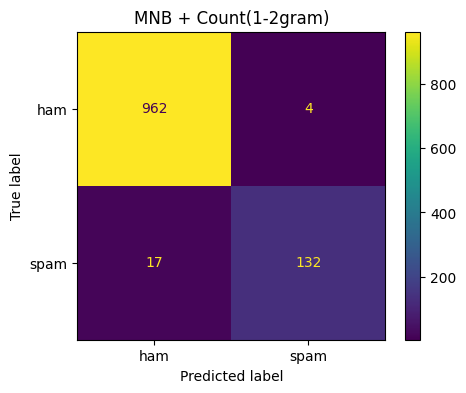


====== MNB + TF-IDF(1-2gram) ======
Accuracy: 0.9650224215246637
              precision    recall  f1-score   support

         ham     0.9612    1.0000    0.9802       966
        spam     1.0000    0.7383    0.8494       149

    accuracy                         0.9650      1115
   macro avg     0.9806    0.8691    0.9148      1115
weighted avg     0.9664    0.9650    0.9627      1115



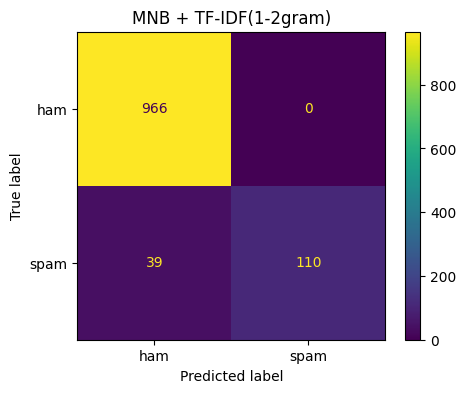


====== BNB + Binary Count(1-2gram) ======
Accuracy: 0.9730941704035875
              precision    recall  f1-score   support

         ham     0.9699    1.0000    0.9847       966
        spam     1.0000    0.7987    0.8881       149

    accuracy                         0.9731      1115
   macro avg     0.9849    0.8993    0.9364      1115
weighted avg     0.9739    0.9731    0.9718      1115



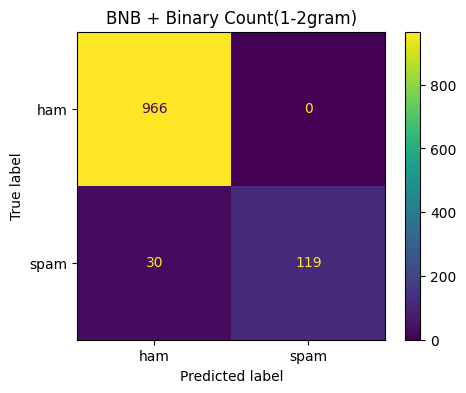


====== KNN + TF-IDF(cosine,k=5) ======
Accuracy: 0.9775784753363229
              precision    recall  f1-score   support

         ham     0.9786    0.9959    0.9872       966
        spam     0.9697    0.8591    0.9110       149

    accuracy                         0.9776      1115
   macro avg     0.9742    0.9275    0.9491      1115
weighted avg     0.9774    0.9776    0.9770      1115



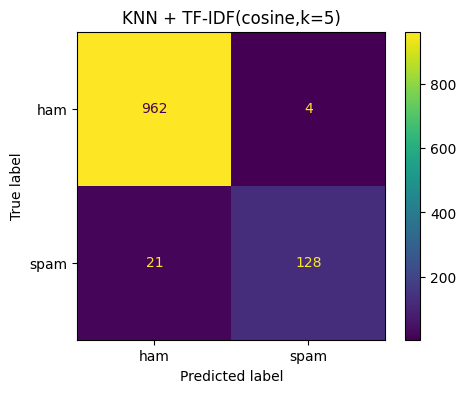


====== DecisionTree + TF-IDF ======
Accuracy: 0.9587443946188341
              precision    recall  f1-score   support

         ham     0.9802    0.9720    0.9761       966
        spam     0.8280    0.8725    0.8497       149

    accuracy                         0.9587      1115
   macro avg     0.9041    0.9223    0.9129      1115
weighted avg     0.9598    0.9587    0.9592      1115



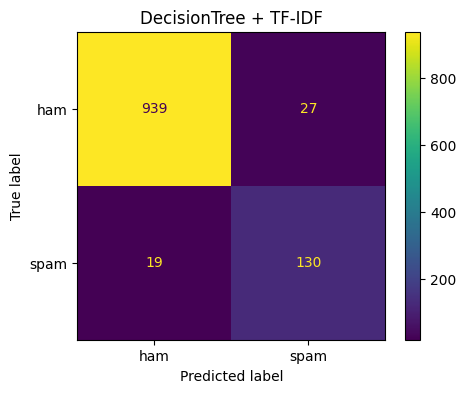


====== GNB + TF-IDF dense(5000) ======
Accuracy: 0.8753363228699551
              precision    recall  f1-score   support

         ham     0.9791    0.8747    0.9240       966
        spam     0.5198    0.8792    0.6534       149

    accuracy                         0.8753      1115
   macro avg     0.7495    0.8770    0.7887      1115
weighted avg     0.9178    0.8753    0.8878      1115



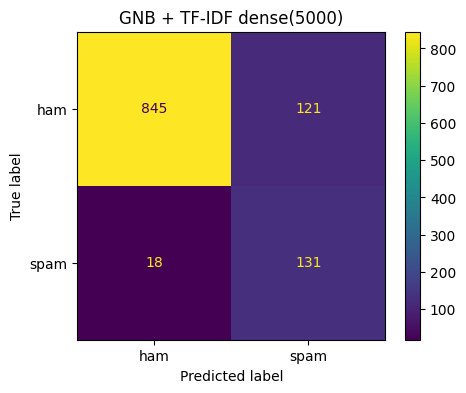

,Accuracy,Precision_pos,Recall_pos,F1_pos
Model,,,,
MNB + Count(1-2gram),0.981166,0.970588,0.885906,0.926316
"KNN + TF-IDF(cosine,k=5)",0.977578,0.969697,0.859060,0.911032
BNB + Binary Count(1-2gram),0.973094,1.000000,0.798658,0.888060
DecisionTree + TF-IDF,0.958744,0.828025,0.872483,0.849673
MNB + TF-IDF(1-2gram),0.965022,1.000000,0.738255,0.849421
GNB + TF-IDF dense(5000),0.875336,0.519841,0.879195,0.653367


In [13]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import pandas as pd
import numpy as np

def eval_and_plot(name, y_true, y_pred):
    print("\n======", name, "======")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, values_format="d")
    ax.set_title(name)
    plt.show()

def get_pos_label(y):
    # pos = 'spam' nếu có, không thì lấy label thiểu số
    vals = pd.Series(y).value_counts()
    if "spam" in vals.index:
        return "spam"
    return vals.idxmin()

POS = get_pos_label(y_test)
print("Positive label (spam-like):", POS)

def metrics_pos(y_true, y_pred, pos_label):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[pos_label], zero_division=0)
    return {"Accuracy": acc, "Precision_pos": float(p[0]), "Recall_pos": float(r[0]), "F1_pos": float(f1[0])}

preds = {}

# 1) MNB + Count
mnb_count = MultinomialNB()
mnb_count.fit(Xtr_count, y_train)
preds["MNB + Count(1-2gram)"] = mnb_count.predict(Xte_count)

# 2) MNB + TF-IDF
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(Xtr_tfidf, y_train)
preds["MNB + TF-IDF(1-2gram)"] = mnb_tfidf.predict(Xte_tfidf)

# 3) BNB + Binary
bnb = BernoulliNB()
bnb.fit(Xtr_bin, y_train)
preds["BNB + Binary Count(1-2gram)"] = bnb.predict(Xte_bin)

# 4) KNN + TF-IDF (cosine)
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine", algorithm="brute")
knn.fit(Xtr_tfidf, y_train)
preds["KNN + TF-IDF(cosine,k=5)"] = knn.predict(Xte_tfidf)

# 5) Decision Tree + TF-IDF
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt.fit(Xtr_tfidf, y_train)
preds["DecisionTree + TF-IDF"] = dt.predict(Xte_tfidf)

# (Optional) 6) GaussianNB (cần dense) - thường yếu cho text nhưng để đủ thuật toán
# Giới hạn feature để đỡ nặng
tfidf_dense = TfidfVectorizer(max_features=5000)
Xtr_g = tfidf_dense.fit_transform(X_train).toarray()
Xte_g = tfidf_dense.transform(X_test).toarray()

gnb = GaussianNB()
gnb.fit(Xtr_g, y_train)
preds["GNB + TF-IDF dense(5000)"] = gnb.predict(Xte_g)

# ===== In report + confusion matrix cho từng model =====
for name, ypred in preds.items():
    eval_and_plot(name, y_test, ypred)

# ===== Bảng tổng hợp (ưu tiên lớp spam-like) =====
rows = []
for name, ypred in preds.items():
    row = metrics_pos(y_test, ypred, POS)
    row["Model"] = name
    rows.append(row)

df_summary = pd.DataFrame(rows).set_index("Model").sort_values(["F1_pos","Recall_pos"], ascending=False)
display(df_summary)


CELL 14 — (Thêm) Biểu đồ tổng hợp F1_pos của các mô hình (rất trực quan)

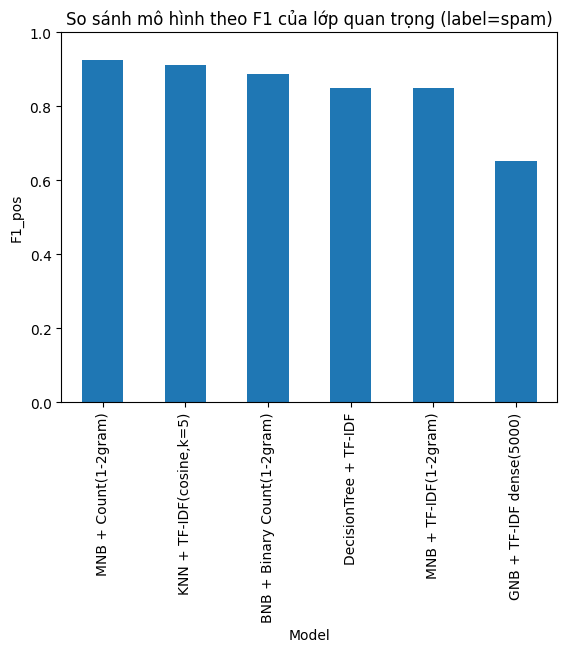

In [14]:
import matplotlib.pyplot as plt

plt.figure()
df_summary["F1_pos"].plot(kind="bar")
plt.title(f"So sánh mô hình theo F1 của lớp quan trọng (label={POS})")
plt.xlabel("Model")
plt.ylabel("F1_pos")
plt.ylim(0, 1)
plt.show()


------
-----
-------
-------
-------
--------
---------
--------


XỬ LÝ MẤT CÂN BẰNG

In [15]:
!pip -q install imbalanced-learn

import pandas as pd
from imblearn.over_sampling import RandomOverSampler

print("Train distribution BEFORE:")
print(pd.Series(y_train).value_counts())

ros = RandomOverSampler(random_state=42)

# oversample trên TRAIN cho từng dạng đặc trưng
Xtr_count_os, ytr_os = ros.fit_resample(Xtr_count, y_train)
Xtr_tfidf_os, _      = ros.fit_resample(Xtr_tfidf, y_train)
Xtr_bin_os, _        = ros.fit_resample(Xtr_bin, y_train)

print("\nTrain distribution AFTER (oversampled):")
print(pd.Series(ytr_os).value_counts())

# kiểm tra: test giữ nguyên
print("\nTest distribution (MUST stay same):")
print(pd.Series(y_test).value_counts())


Train distribution BEFORE:
ham     3861
spam     598
Name: count, dtype: int64

Train distribution AFTER (oversampled):
ham     3861
spam    3861
Name: count, dtype: int64

Test distribution (MUST stay same):
ham     966
spam    149
Name: count, dtype: int64


Train lại y hệt baseline nhưng dùng X_train_os / y_train_os

In [16]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

preds_bal = {}

# 1) MNB + Count
mnb_count_os = MultinomialNB()
mnb_count_os.fit(Xtr_count_os, ytr_os)
preds_bal["BALANCED - MNB + Count(1-2gram)"] = mnb_count_os.predict(Xte_count)

# 2) MNB + TF-IDF
mnb_tfidf_os = MultinomialNB()
mnb_tfidf_os.fit(Xtr_tfidf_os, ytr_os)
preds_bal["BALANCED - MNB + TF-IDF(1-2gram)"] = mnb_tfidf_os.predict(Xte_tfidf)

# 3) BNB + Binary
bnb_os = BernoulliNB()
bnb_os.fit(Xtr_bin_os, ytr_os)
preds_bal["BALANCED - BNB + Binary Count(1-2gram)"] = bnb_os.predict(Xte_bin)

# 4) KNN + TF-IDF(cosine,k=5)
knn_os = KNeighborsClassifier(n_neighbors=5, metric="cosine", algorithm="brute")
knn_os.fit(Xtr_tfidf_os, ytr_os)
preds_bal["BALANCED - KNN + TF-IDF(cosine,k=5)"] = knn_os.predict(Xte_tfidf)

# 5) DecisionTree + TF-IDF
dt_os = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_os.fit(Xtr_tfidf_os, ytr_os)
preds_bal["BALANCED - DecisionTree + TF-IDF"] = dt_os.predict(Xte_tfidf)

print("Done training balanced models.")


Done training balanced models.


Đánh giá (2 class + confusion matrix)


====== BALANCED - MNB + Count(1-2gram) ======
Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

         ham     0.9854    0.9814    0.9834       966
        spam     0.8824    0.9060    0.8940       149

    accuracy                         0.9713      1115
   macro avg     0.9339    0.9437    0.9387      1115
weighted avg     0.9717    0.9713    0.9715      1115



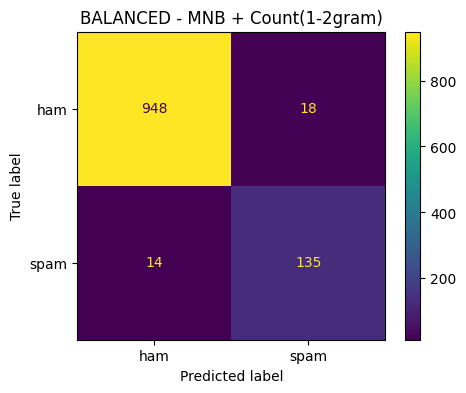


====== BALANCED - MNB + TF-IDF(1-2gram) ======
Accuracy: 0.9721973094170404
              precision    recall  f1-score   support

         ham     0.9895    0.9783    0.9839       966
        spam     0.8688    0.9329    0.8997       149

    accuracy                         0.9722      1115
   macro avg     0.9291    0.9556    0.9418      1115
weighted avg     0.9734    0.9722    0.9726      1115



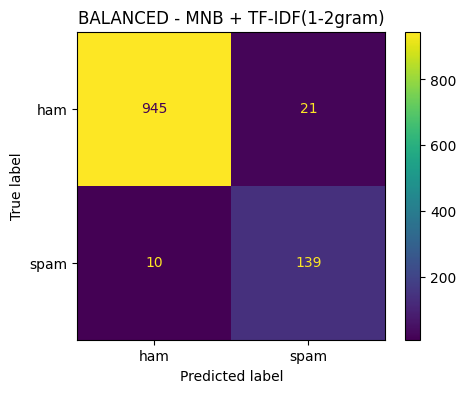


====== BALANCED - BNB + Binary Count(1-2gram) ======
Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

         ham     0.9807    0.9990    0.9897       966
        spam     0.9924    0.8725    0.9286       149

    accuracy                         0.9821      1115
   macro avg     0.9865    0.9357    0.9592      1115
weighted avg     0.9823    0.9821    0.9816      1115



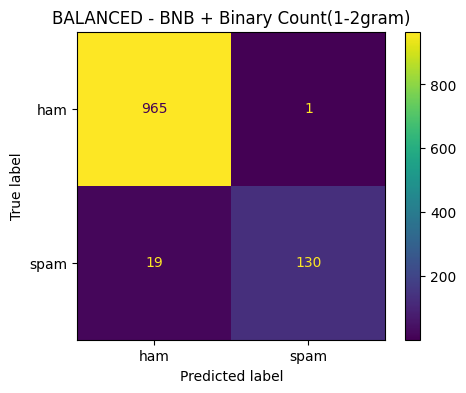


====== BALANCED - KNN + TF-IDF(cosine,k=5) ======
Accuracy: 0.9605381165919282
              precision    recall  f1-score   support

         ham     0.9904    0.9638    0.9769       966
        spam     0.8000    0.9396    0.8642       149

    accuracy                         0.9605      1115
   macro avg     0.8952    0.9517    0.9206      1115
weighted avg     0.9650    0.9605    0.9619      1115



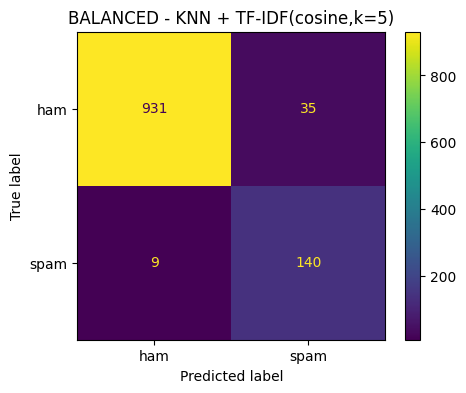


====== BALANCED - DecisionTree + TF-IDF ======
Accuracy: 0.9614349775784753
              precision    recall  f1-score   support

         ham     0.9812    0.9741    0.9777       966
        spam     0.8397    0.8792    0.8590       149

    accuracy                         0.9614      1115
   macro avg     0.9105    0.9267    0.9183      1115
weighted avg     0.9623    0.9614    0.9618      1115



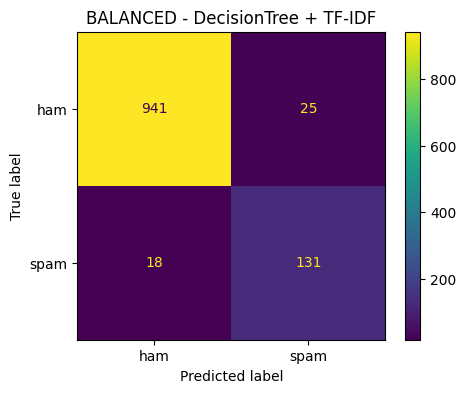

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def eval_and_plot(name, y_true, y_pred):
    print("\n======", name, "======")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, values_format="d")
    ax.set_title(name)
    plt.show()

for name, pred in preds_bal.items():
    eval_and_plot(name, y_test, pred)


Bảng tổng hợp (Accuracy + Precision/Recall/F1 của lớp spam)

In [18]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

POS = "spam" if "spam" in set(y_test) else pd.Series(y_test).value_counts().idxmin()
print("Positive label (spam-like):", POS)

rows = []
for name, pred in preds_bal.items():
    acc = accuracy_score(y_test, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, labels=[POS], zero_division=0)
    rows.append({
        "Model": name.replace("BALANCED - ", ""),
        "Accuracy": acc,
        "Precision_spam": float(p[0]),
        "Recall_spam": float(r[0]),
        "F1_spam": float(f1[0]),
    })

df_balanced = pd.DataFrame(rows).set_index("Model").sort_values(["F1_spam","Recall_spam"], ascending=False)
display(df_balanced)


Positive label (spam-like): spam


,Accuracy,Precision_spam,Recall_spam,F1_spam
Model,,,,
BNB + Binary Count(1-2gram),0.982063,0.992366,0.872483,0.928571
MNB + TF-IDF(1-2gram),0.972197,0.868750,0.932886,0.899676
MNB + Count(1-2gram),0.971300,0.882353,0.906040,0.894040
"KNN + TF-IDF(cosine,k=5)",0.960538,0.800000,0.939597,0.864198
DecisionTree + TF-IDF,0.961435,0.839744,0.879195,0.859016


In [19]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

labels = ["ham", "spam"]  # vì dataset của bạn đã map nhãn như vậy

rows = []
for name, pred in preds_bal.items():
    acc = accuracy_score(y_test, pred)

    p, r, f1, s = precision_recall_fscore_support(
        y_test, pred, labels=labels, zero_division=0
    )

    rows.append({
        "Model": name.replace("BALANCED - ", ""),
        "Accuracy": acc,

        "Precision_ham":  float(p[0]),
        "Recall_ham":     float(r[0]),
        "F1_ham":         float(f1[0]),
        "Support_ham":    int(s[0]),

        "Precision_spam": float(p[1]),
        "Recall_spam":    float(r[1]),
        "F1_spam":        float(f1[1]),
        "Support_spam":   int(s[1]),
    })

df_balanced_2class = pd.DataFrame(rows).set_index("Model").sort_values(
    ["F1_spam", "Recall_spam"], ascending=False
)

display(df_balanced_2class)


,Accuracy,Precision_ham,Recall_ham,F1_ham,Support_ham,Precision_spam,Recall_spam,F1_spam,Support_spam
Model,,,,,,,,,
BNB + Binary Count(1-2gram),0.982063,0.980691,0.998965,0.989744,966,0.992366,0.872483,0.928571,149
MNB + TF-IDF(1-2gram),0.972197,0.989529,0.978261,0.983863,966,0.868750,0.932886,0.899676,149
MNB + Count(1-2gram),0.971300,0.985447,0.981366,0.983402,966,0.882353,0.906040,0.894040,149
"KNN + TF-IDF(cosine,k=5)",0.960538,0.990426,0.963768,0.976915,966,0.800000,0.939597,0.864198,149
DecisionTree + TF-IDF,0.961435,0.981230,0.974120,0.977662,966,0.839744,0.879195,0.859016,149


Code thêm Sentence Embeddings

In [20]:
!pip -q install -U sentence-transformers

import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

X = data["text_clean"].tolist()
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model embedding gọn, phổ biến
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

Xtr_emb = embed_model.encode(X_train, batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
Xte_emb = embed_model.encode(X_test,  batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

print("Embeddings shape:", Xtr_emb.shape, Xte_emb.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

Embeddings shape: (4459, 384) (1115, 384)



====== Sentence Embeddings + KNN(k=5) ======
Accuracy: 0.9766816143497757
              precision    recall  f1-score   support

         ham     0.9916    0.9814    0.9865       966
        spam     0.8868    0.9463    0.9156       149

    accuracy                         0.9767      1115
   macro avg     0.9392    0.9638    0.9510      1115
weighted avg     0.9776    0.9767    0.9770      1115



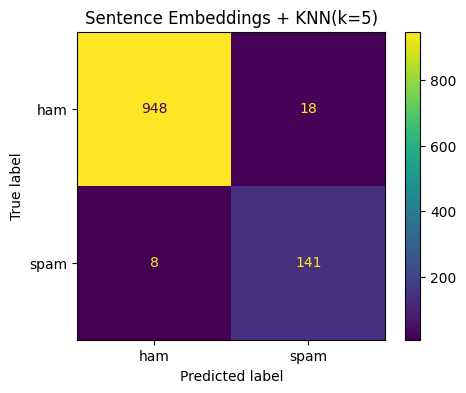


====== Sentence Embeddings + LogisticRegression ======
Accuracy: 0.9811659192825112
              precision    recall  f1-score   support

         ham     0.9826    0.9959    0.9892       966
        spam     0.9706    0.8859    0.9263       149

    accuracy                         0.9812      1115
   macro avg     0.9766    0.9409    0.9578      1115
weighted avg     0.9810    0.9812    0.9808      1115



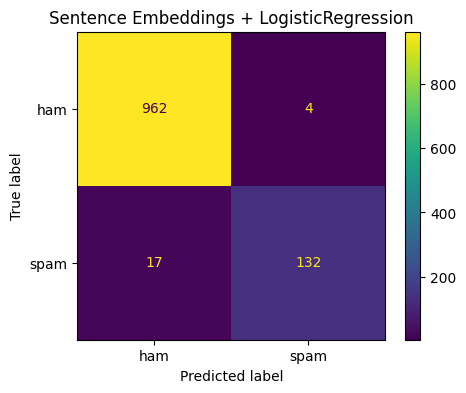

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def eval_and_plot(name, y_true, y_pred):
    print("\n======", name, "======")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, values_format="d")
    ax.set_title(name)
    plt.show()

# KNN (cosine ~ dùng normalize_embeddings=True thì euclidean gần cosine)
knn_emb = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn_emb.fit(Xtr_emb, y_train)
pred_knn_emb = knn_emb.predict(Xte_emb)
eval_and_plot("Sentence Embeddings + KNN(k=5)", y_test, pred_knn_emb)

# Logistic Regression (rất mạnh cho embedding)
lr_emb = LogisticRegression(max_iter=2000)
lr_emb.fit(Xtr_emb, y_train)
pred_lr_emb = lr_emb.predict(Xte_emb)
eval_and_plot("Sentence Embeddings + LogisticRegression", y_test, pred_lr_emb)



====== Embeddings + LogisticRegression(class_weight=balanced) ======
Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

         ham     0.9937    0.9731    0.9833       966
        spam     0.8462    0.9597    0.8994       149

    accuracy                         0.9713      1115
   macro avg     0.9199    0.9664    0.9413      1115
weighted avg     0.9739    0.9713    0.9721      1115



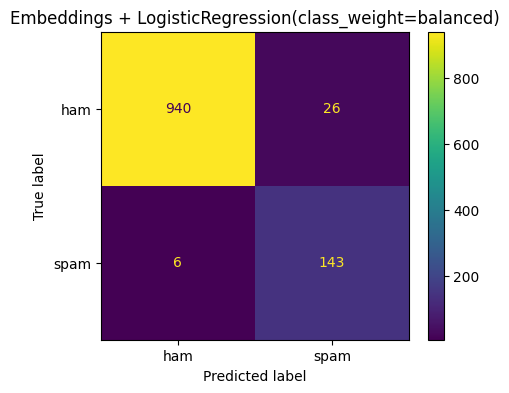

In [22]:
from sklearn.linear_model import LogisticRegression

lr_emb_bal = LogisticRegression(max_iter=2000, class_weight="balanced")
lr_emb_bal.fit(Xtr_emb, y_train)
pred_lr_emb_bal = lr_emb_bal.predict(Xte_emb)
eval_and_plot("Embeddings + LogisticRegression(class_weight=balanced)", y_test, pred_lr_emb_bal)


In [25]:
import numpy as np

print("KNN unique preds:", np.unique(pred_knn_emb, return_counts=True))
print("LR unique preds :", np.unique(pred_lr_emb, return_counts=True))

# nếu bạn còn pred_mnb_count từ baseline
print("Equal LR vs MNB_count?:", np.array_equal(pred_lr_emb, preds["MNB + Count(1-2gram)"]))

KNN unique preds: (array(['ham', 'spam'], dtype=object), array([956, 159]))
LR unique preds : (array(['ham', 'spam'], dtype=object), array([979, 136]))
Equal LR vs MNB_count?: False


Trực quan hoá

In [26]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def make_df_2class(preds_dict, y_true, prefix_remove=""):
    labels = ["ham","spam"]
    rows = []
    for name, y_pred in preds_dict.items():
        acc = accuracy_score(y_true, y_pred)
        p, r, f1, s = precision_recall_fscore_support(
            y_true, y_pred, labels=labels, zero_division=0
        )
        rows.append({
            "Model": name.replace(prefix_remove, ""),
            "Accuracy": acc,

            "Precision_ham":  float(p[0]),
            "Recall_ham":     float(r[0]),
            "F1_ham":         float(f1[0]),
            "Support_ham":    int(s[0]),

            "Precision_spam": float(p[1]),
            "Recall_spam":    float(r[1]),
            "F1_spam":        float(f1[1]),
            "Support_spam":   int(s[1]),
        })
    return pd.DataFrame(rows).set_index("Model")


In [27]:
# ===== baseline + balanced =====
df_base_2class = make_df_2class(preds, y_test, prefix_remove="")
df_balanced_2class = make_df_2class(preds_bal, y_test, prefix_remove="BALANCED - ")

print("Created df_base_2class:", df_base_2class.shape)
print("Created df_balanced_2class:", df_balanced_2class.shape)

display(df_base_2class.sort_values("F1_spam", ascending=False))
display(df_balanced_2class.sort_values("F1_spam", ascending=False))

# ===== embeddings (nếu có) =====
df_embed_2class = None
try:
    preds_embed = {
        "Embeddings + KNN(k=5)": pred_knn_emb,
        "Embeddings + LogisticRegression": pred_lr_emb,
        "Embeddings + LogisticRegression(balanced)": pred_lr_emb_bal,
    }
    df_embed_2class = make_df_2class(preds_embed, y_test, prefix_remove="")
    print("Created df_embed_2class:", df_embed_2class.shape)
    display(df_embed_2class.sort_values("F1_spam", ascending=False))
except NameError:
    print("Chưa có biến pred_knn_emb / pred_lr_emb / pred_lr_emb_bal => bỏ qua embeddings.")


Created df_base_2class: (6, 9)
Created df_balanced_2class: (5, 9)


,Accuracy,Precision_ham,Recall_ham,F1_ham,Support_ham,Precision_spam,Recall_spam,F1_spam,Support_spam
Model,,,,,,,,,
MNB + Count(1-2gram),0.981166,0.982635,0.995859,0.989203,966,0.970588,0.885906,0.926316,149
"KNN + TF-IDF(cosine,k=5)",0.977578,0.978637,0.995859,0.987173,966,0.969697,0.859060,0.911032,149
BNB + Binary Count(1-2gram),0.973094,0.969880,1.000000,0.984709,966,1.000000,0.798658,0.888060,149
DecisionTree + TF-IDF,0.958744,0.980167,0.972050,0.976091,966,0.828025,0.872483,0.849673,149
MNB + TF-IDF(1-2gram),0.965022,0.961194,1.000000,0.980213,966,1.000000,0.738255,0.849421,149
GNB + TF-IDF dense(5000),0.875336,0.979143,0.874741,0.924002,966,0.519841,0.879195,0.653367,149


,Accuracy,Precision_ham,Recall_ham,F1_ham,Support_ham,Precision_spam,Recall_spam,F1_spam,Support_spam
Model,,,,,,,,,
BNB + Binary Count(1-2gram),0.982063,0.980691,0.998965,0.989744,966,0.992366,0.872483,0.928571,149
MNB + TF-IDF(1-2gram),0.972197,0.989529,0.978261,0.983863,966,0.868750,0.932886,0.899676,149
MNB + Count(1-2gram),0.971300,0.985447,0.981366,0.983402,966,0.882353,0.906040,0.894040,149
"KNN + TF-IDF(cosine,k=5)",0.960538,0.990426,0.963768,0.976915,966,0.800000,0.939597,0.864198,149
DecisionTree + TF-IDF,0.961435,0.981230,0.974120,0.977662,966,0.839744,0.879195,0.859016,149


Created df_embed_2class: (3, 9)


,Accuracy,Precision_ham,Recall_ham,F1_ham,Support_ham,Precision_spam,Recall_spam,F1_spam,Support_spam
Model,,,,,,,,,
Embeddings + LogisticRegression,0.981166,0.982635,0.995859,0.989203,966,0.970588,0.885906,0.926316,149
Embeddings + KNN(k=5),0.976682,0.991632,0.981366,0.986472,966,0.886792,0.946309,0.915584,149
Embeddings + LogisticRegression(balanced),0.971300,0.993658,0.973085,0.983264,966,0.846154,0.959732,0.899371,149


,Model,Accuracy,Precision_ham,Recall_ham,F1_ham,Support_ham,Precision_spam,Recall_spam,F1_spam,Support_spam,Setting
0,MNB + Count(1-2gram),0.981166,0.982635,0.995859,0.989203,966,0.970588,0.885906,0.926316,149,No balancing
1,MNB + TF-IDF(1-2gram),0.965022,0.961194,1.000000,0.980213,966,1.000000,0.738255,0.849421,149,No balancing
2,BNB + Binary Count(1-2gram),0.973094,0.969880,1.000000,0.984709,966,1.000000,0.798658,0.888060,149,No balancing
3,"KNN + TF-IDF(cosine,k=5)",0.977578,0.978637,0.995859,0.987173,966,0.969697,0.859060,0.911032,149,No balancing
4,DecisionTree + TF-IDF,0.958744,0.980167,0.972050,0.976091,966,0.828025,0.872483,0.849673,149,No balancing


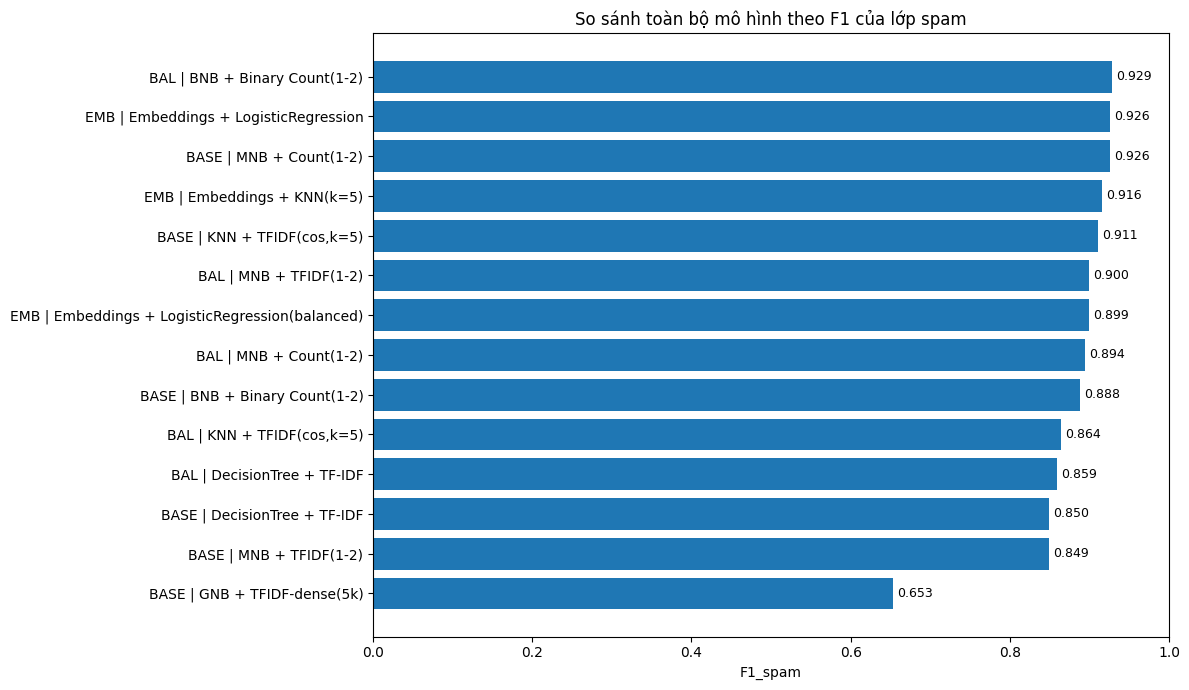

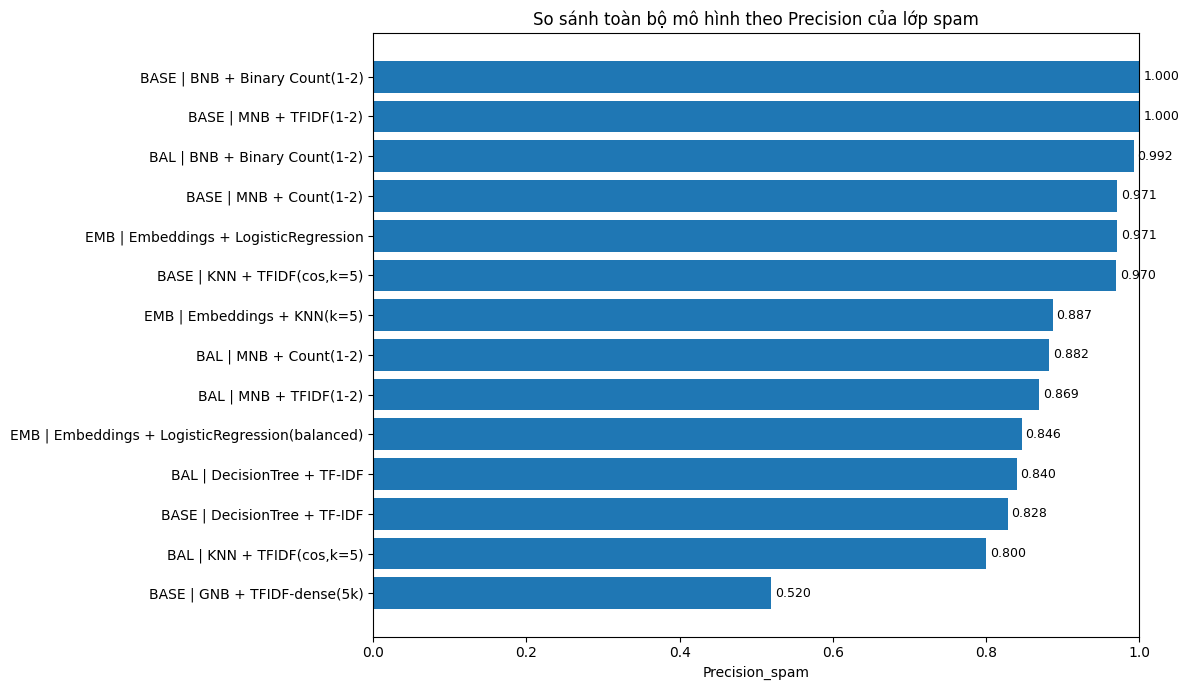

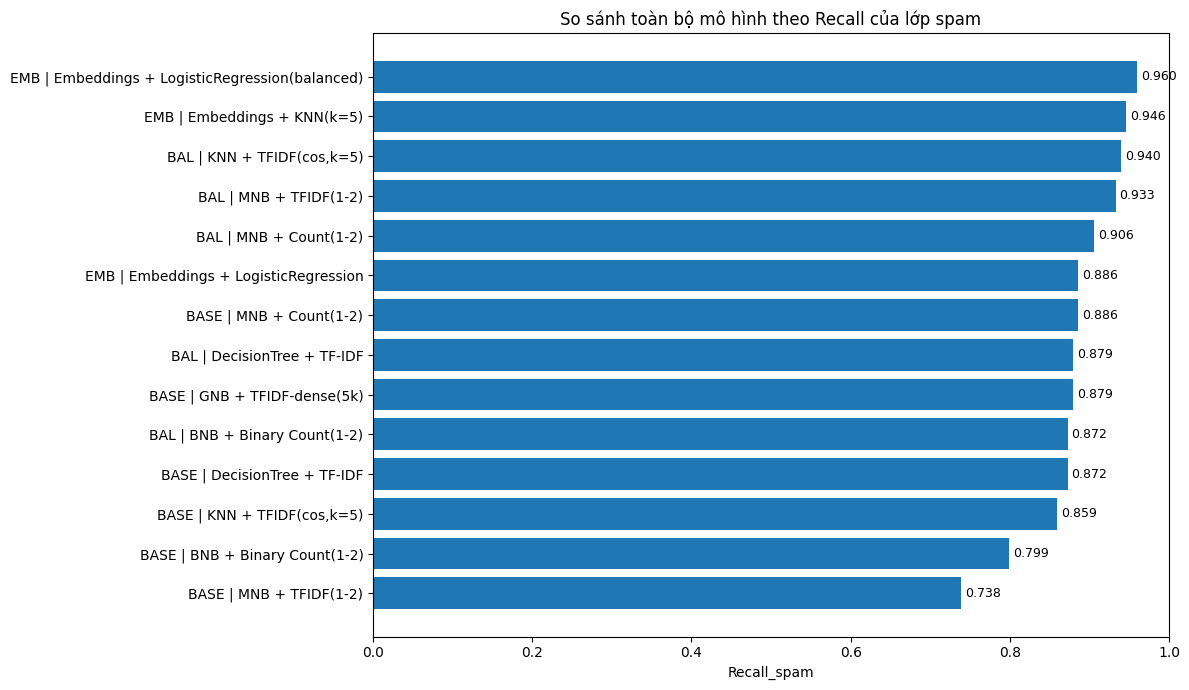

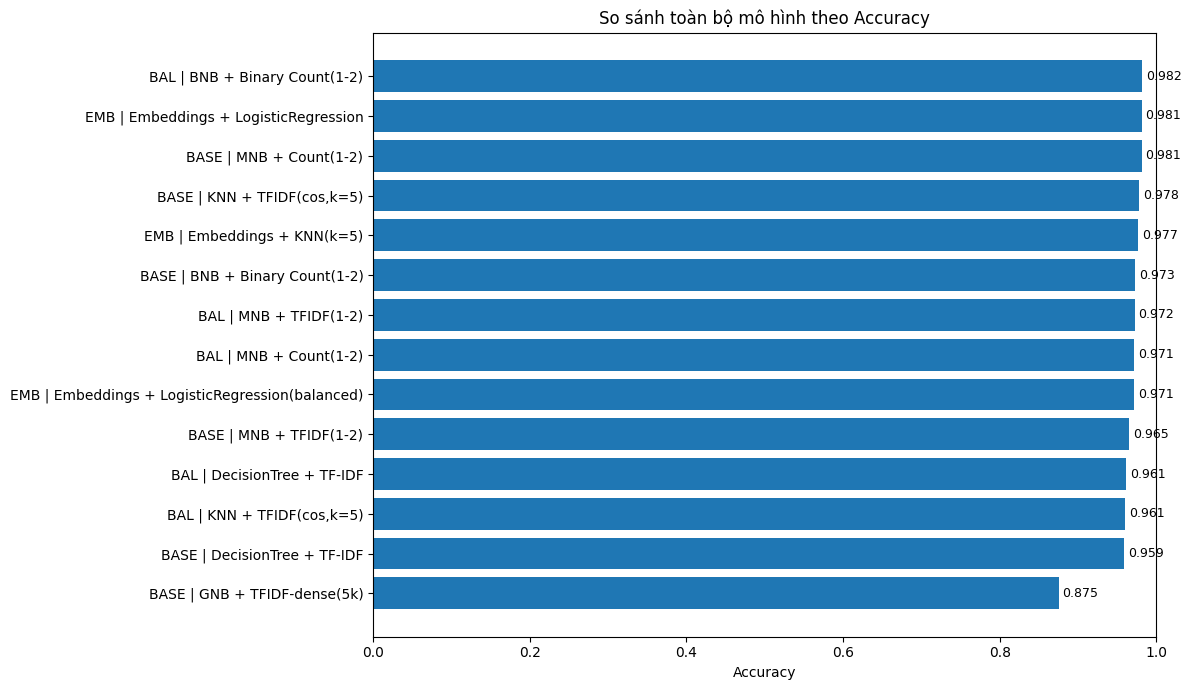

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

def to_long(df, setting_name):
    tmp = df.copy()
    tmp["Setting"] = setting_name
    tmp = tmp.reset_index()
    return tmp

dfs = [
    to_long(df_base_2class, "No balancing"),
    to_long(df_balanced_2class, "Balanced"),
]

if df_embed_2class is not None:
    dfs.append(to_long(df_embed_2class, "Embeddings"))

df_all = pd.concat(dfs, ignore_index=True)
display(df_all.head())

# ===== Rút gọn tên cho dễ nhìn =====
def short_name(row):
    s = row["Setting"]
    m = row["Model"]
    s2 = {"No balancing":"BASE", "Balanced":"BAL", "Embeddings":"EMB"}.get(s, s)

    m = m.replace("TF-IDF(1-2gram)", "TFIDF(1-2)")
    m = m.replace("Count(1-2gram)", "Count(1-2)")
    m = m.replace("Binary Count(1-2gram)", "BinCount(1-2)")
    m = m.replace("TF-IDF(cosine,k=5)", "TFIDF(cos,k=5)")
    m = m.replace("TF-IDF dense(5000)", "TFIDF-dense(5k)")

    return f"{s2} | {m}"

df_all["Name"] = df_all.apply(short_name, axis=1)

# ===== Hàm vẽ bar ngang cho 1 metric =====
def plot_barh(metric_col, title):
    df_plot = df_all.sort_values(metric_col, ascending=True)  # để bar lớn nằm trên
    plt.figure(figsize=(12, 7))
    plt.barh(df_plot["Name"], df_plot[metric_col])
    plt.title(title)
    plt.xlabel(metric_col)
    plt.xlim(0, 1)

    # ghi số lên cột
    for i, v in enumerate(df_plot[metric_col].values):
        plt.text(v + 0.005, i, f"{v:.3f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

# ===== 4 biểu đồ ngang =====
plot_barh("F1_spam",        "So sánh toàn bộ mô hình theo F1 của lớp spam")
plot_barh("Precision_spam", "So sánh toàn bộ mô hình theo Precision của lớp spam")
plot_barh("Recall_spam",    "So sánh toàn bộ mô hình theo Recall của lớp spam")
plot_barh("Accuracy",       "So sánh toàn bộ mô hình theo Accuracy")


### Lưu mô hình để sử dụng sau này
Để lưu và tải mô hình, chúng ta có thể dùng thư viện `joblib` hoặc `pickle`. Ở đây ta chọn `joblib` vì nó hiệu quả hơn với các đối tượng Sci-kit Learn.

Ta sẽ lưu một số mô hình hoạt động tốt nhất từ các bước trước cùng với các `vectorizer` hoặc `embedding model` tương ứng.

In [29]:
import joblib
import os

# Tạo thư mục để lưu các mô hình
output_dir = "./saved_models"
os.makedirs(output_dir, exist_ok=True)

print(f"Lưu mô hình vào thư mục: {output_dir}")

# 1. Lưu mô hình BNB + Binary Count(1-2gram) và vec_bin
joblib.dump(bnb_os, os.path.join(output_dir, "bnb_binary_oversampled.joblib"))
joblib.dump(vec_bin, os.path.join(output_dir, "vec_binary.joblib"))
print("Đã lưu: bnb_os và vec_bin")

# 2. Lưu mô hình Embeddings + LogisticRegression và embed_model
joblib.dump(lr_emb, os.path.join(output_dir, "lr_embedding.joblib"))
joblib.dump(embed_model, os.path.join(output_dir, "sentence_transformer_embed_model.joblib"))
print("Đã lưu: lr_emb và embed_model")

print("\nHoàn tất lưu các mô hình.")

Lưu mô hình vào thư mục: ./saved_models
Đã lưu: bnb_os và vec_bin
Đã lưu: lr_emb và embed_model

Hoàn tất lưu các mô hình.


### Ví dụ về cách tải và sử dụng lại mô hình

Sau khi đã lưu, bạn có thể tải lại và sử dụng mô hình để dự đoán trên dữ liệu mới.

Đầu tiên, tải lại các đối tượng đã lưu:

In [30]:
import joblib
import os

output_dir = "./saved_models"

# Tải lại mô hình BNB + Binary Count và vectorizer
loaded_bnb_os = joblib.load(os.path.join(output_dir, "bnb_binary_oversampled.joblib"))
loaded_vec_bin = joblib.load(os.path.join(output_dir, "vec_binary.joblib"))

# Tải lại mô hình LR + Embeddings và embedding model
loaded_lr_emb = joblib.load(os.path.join(output_dir, "lr_embedding.joblib"))
loaded_embed_model = joblib.load(os.path.join(output_dir, "sentence_transformer_embed_model.joblib"))

print("Đã tải lại các mô hình và vectorizer/embedding model.")

# Ví dụ dự đoán trên một tin nhắn mới
new_sms = "Free entry in our £250 weekly competition just text JOIN to 87070 now!"
new_sms_clean = preprocess_sms(new_sms)
print(f"\nTin nhắn gốc: {new_sms}")
print(f"Tin nhắn đã tiền xử lý: {new_sms_clean}")

# Dự đoán bằng mô hình BNB + Binary Count
x_new_bin = loaded_vec_bin.transform([new_sms_clean])
pred_bnb = loaded_bnb_os.predict(x_new_bin)
print(f"Dự đoán của BNB + Binary Count: {pred_bnb[0]}")

# Dự đoán bằng mô hình LR + Embeddings
x_new_emb = loaded_embed_model.encode([new_sms_clean], convert_to_numpy=True, normalize_embeddings=True)
pred_lr_emb = loaded_lr_emb.predict(x_new_emb)
print(f"Dự đoán của LR + Embeddings: {pred_lr_emb[0]}")

new_sms_ham = "Hello, how are you doing today?"
new_sms_ham_clean = preprocess_sms(new_sms_ham)
print(f"\nTin nhắn gốc: {new_sms_ham}")
print(f"Tin nhắn đã tiền xử lý: {new_sms_ham_clean}")

x_new_bin_ham = loaded_vec_bin.transform([new_sms_ham_clean])
pred_bnb_ham = loaded_bnb_os.predict(x_new_bin_ham)
print(f"Dự đoán của BNB + Binary Count: {pred_bnb_ham[0]}")

x_new_emb_ham = loaded_embed_model.encode([new_sms_ham_clean], convert_to_numpy=True, normalize_embeddings=True)
pred_lr_emb_ham = loaded_lr_emb.predict(x_new_emb_ham)
print(f"Dự đoán của LR + Embeddings: {pred_lr_emb_ham[0]}")

Đã tải lại các mô hình và vectorizer/embedding model.

Tin nhắn gốc: Free entry in our £250 weekly competition just text JOIN to 87070 now!
Tin nhắn đã tiền xử lý: free entry in our < > weekly competition just text join to < > now
Dự đoán của BNB + Binary Count: spam
Dự đoán của LR + Embeddings: spam

Tin nhắn gốc: Hello, how are you doing today?
Tin nhắn đã tiền xử lý: hello how are you doing today
Dự đoán của BNB + Binary Count: ham
Dự đoán của LR + Embeddings: ham
